In [50]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime
from RoutePlanner import Plot

In [51]:
OptInfo = {}
X     = [230,360]
Y     = [-80,-40]
d     = [5,2.5]
OptInfo['Start Time']           = '2017-03-15'
OptInfo['End Time']             = '2017-03-16'
OptInfo['WayPoints']            = '../../resources/WayPoints.csv'
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'

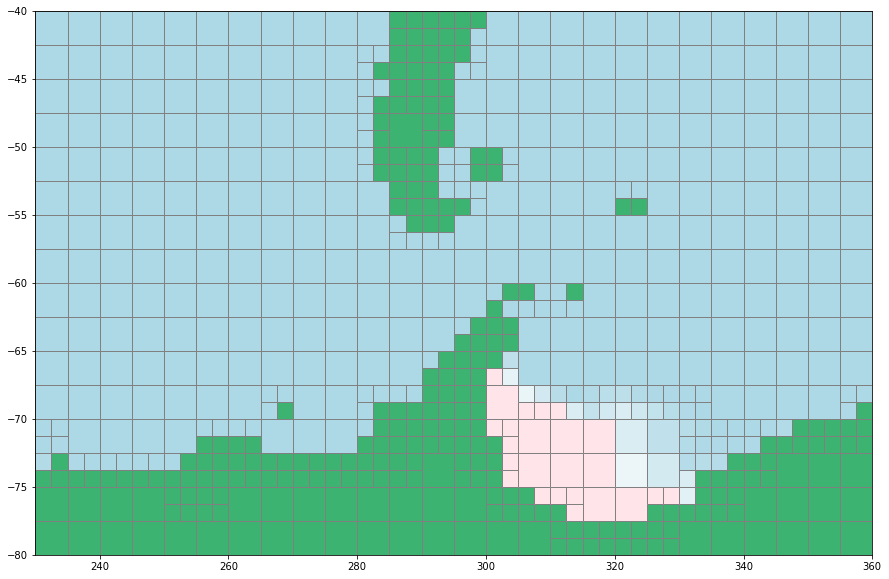

In [103]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(X[0],X[1],Y[0],Y[1],d[0],d[1])
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(1)
Plot.Mesh(cellGrid)

=== Processing Waypoint = Palmer ===


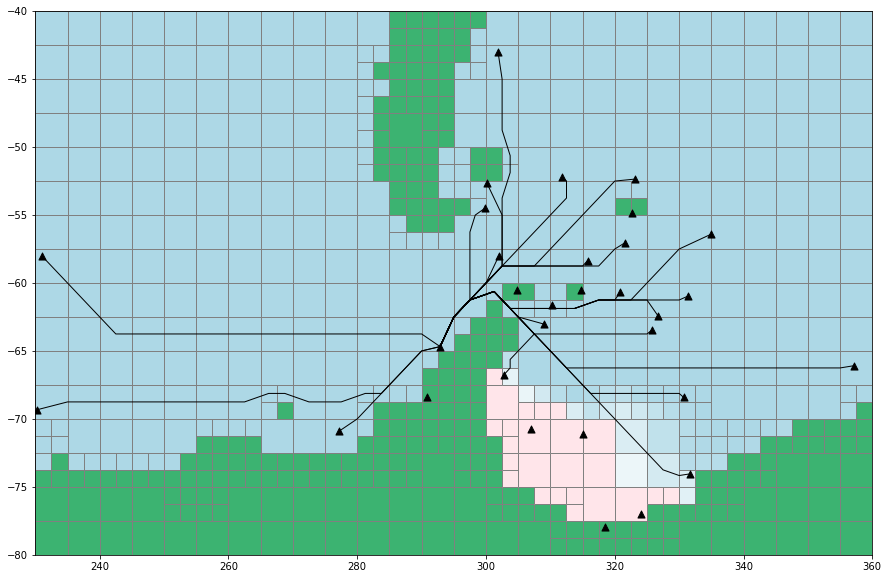

In [104]:
TT = TravelTime(cellGrid,OptInfo)
Paths = TT.Paths(source_waypoints=['Palmer'],verbrose=True)#,end_waypoints=['NorthPeninsula'])
Plot.Paths(cellGrid,Paths,routepoints=False,Waypoints=TT.OptInfo['WayPoints'])

In [195]:
#Paths to GeoJSON
import numpy as np
import json
import copy

#  { "type": "FeatureCollection",
#     "features": [
#       { "type": "Feature",
#         "geometry": {"type": "Point", "coordinates": [102.0, 0.5]},
#         "properties": {"prop0": "value0"}
#         },
#       { "type": "Feature",
#         "geometry": {
#           "type": "LineString",
#           "coordinates": [
#             [102.0, 0.0], [103.0, 1.0], [104.0, 0.0], [105.0, 1.0]
#             ]
#           },

def PathsJSON(Paths):
    GeoJSON = {}
    GeoJSON['type'] = "FeatureCollection"
    GeoJSON['features'] = []
    Pths = copy.deepcopy(Paths)
    for path in Pths:
        if np.isinf(path['Time']):
            continue
        
        points = path['Path']['Points']
        points[:,0] = points[:,0]-360

        pt = {}
        pt['type']     = 'Feature'
        pt['geometry'] = {}
        pt['geometry']['type'] = 'LineString'
        pt['geometry']['coordinates'] = path['Path']['Points'].tolist()
        GeoJSON['features'].append(pt)
    return GeoJSON




def WaypointsJSON(Waypoints):
    GeoJSON = {}
    GeoJSON['type'] = "FeatureCollection"
    GeoJSON['features'] = []
    for idx,wpt in Waypoints.iterrows():
        pt = {}
        pt['type']     = 'Feature'
        pt['geometry'] = {}
        pt['geometry']['type'] = 'Point'

        loc = wpt[['Long','Lat']]
        loc[0] = loc[0]-360
        pt['geometry']['coordinates'] = loc.tolist()
        pt['properties'] = {}
        pt['properties']['name'] = wpt['Name'] 
        pt['properties']['size'] = 2
        GeoJSON['features'].append(pt)  
    return GeoJSON


def MapWaypoints(Waypoints,map):
    for idx,wpt in Waypoints.iterrows():
        pt = {}
        pt['type']     = 'Feature'
        pt['geometry'] = {}
        pt['geometry']['type'] = 'Point'

        loc = wpt[['Long','Lat']]
        loc[0] = loc[0]-360
        folium.Circle(
            location=[loc[1],loc[0]],
            radius=20000,
            fill=True,
            color='#FF7400',
            #fill_opacity=0.7
        ).add_to(map)





def MeshJSON(cellGrid):
    GeoJSON = {}
    GeoJSON['type'] = "FeatureCollection"
    GeoJSON['features'] = []
    for ii in range(len(cellGrid.cellBoxes)):
        bounds      = np.array(cellGrid.cellBoxes[ii].getBounds())
        bounds[:,0] = bounds[:,0]-360
        pt = {}
        pt['type']     = 'Feature'
        pt['geometry'] = {}
        pt['geometry']['type'] = 'Polygon'
        pt['geometry']['coordinates'] = bounds.tolist()
        GeoJSON['features'].append(pt)  
    return GeoJSON
    

In [196]:

# Example Maps 'http://leaflet-extras.github.io/leaflet-providers/preview/'

style = {'fillColor': '#00FFFFFF', 'color': '#00FFFFFF'}

import folium
m = folium.Map(location=[-65, -45],zoom_start=3.2,tiles='https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}.png',attr="toner-bcg")
folium.GeoJson(PathsJSON(Paths),name='Paths').add_to(m)
#folium.GeoJson(WaypointsJSON(TT.OptInfo['WayPoints']),name='Waypoints',style_function=lambda x:style).add_to(m)
MapWaypoints(TT.OptInfo['WayPoints'],m)
folium.GeoJson(MeshJSON(cellGrid),style_function=lambda x: {'color': 'black'}).add_to(m)
folium.LayerControl().add_to(m)
m.save('Test.html')

In [45]:
SmoothedPaths = TT.PathSmoothing([Paths[0]],maxiter=50)

 PATH: Palmer -> NorthPeninsula 


/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:578: RuntimeWarning: invalid value encountered in double_scalars
  dX2 = (-r2*(D2*v2 + r2*C2*(Y-y)))/X2


(-63.5, -63.0)

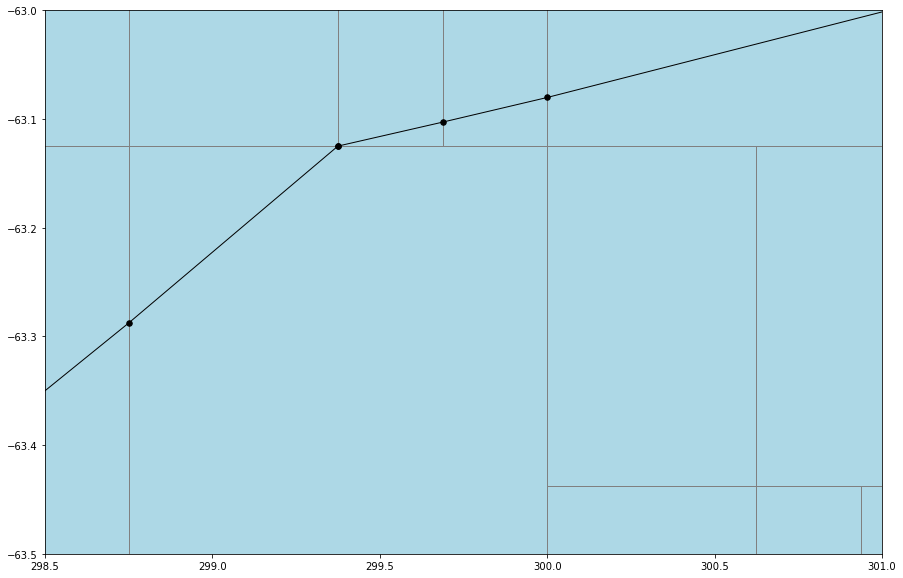

In [49]:
ax = Plot.Paths(cellGrid,SmoothedPaths,routepoints=True,Waypoints=TT.OptInfo['WayPoints'],return_ax=True)
ax.set_xlim([290,310])
ax.set_ylim([-65,-60])

ax.set_xlim([298.5,301])
ax.set_ylim([-63.5,-63])


In [ ]:
Plot.Paths2KML(SmoothedPaths,'RoutePaths_Smoothed.kml')
Plot.Paths2KML(Paths,'RoutePaths_NonSmoothed.kml')
Plot.Mesh2KML(cellGrid,'RoutePaths_Mesh.kml',MaxIce=0.8)
Plot.WayPoints2KML(TT.OptInfo['WayPoints'],'RoutePaths_WayPoints.kml')

In [ ]:
ax = Plot.Paths(cellGrid,SmoothedPaths,routepoints=True,Waypoints=TT.OptInfo['WayPoints'],return_ax=True)
ax.set_ylim([-72,-67])
ax.set_xlim([270,300])

Sp=(287.6112854450627,-67.5);Cp=(285.0,-68.23362159857918);Np=(283.71376404653165,-68.75)
ax.scatter(Sp[0],Sp[1],50,'r',zorder=200)
ax.scatter(Cp[0],Cp[1],50,'r',zorder=200)
ax.scatter(Np[0],Np[1],50,'r',zorder=200)


import numpy as np
from shapely.geometry import Polygon
Cp_cells = TT.Mesh.getCellBox(Cp[0],Cp[1])
Sp_cells = TT.Mesh.getCellBox(Sp[0],Sp[1])
CrossingPoints = []
Bxs = []
for Spc in Sp_cells:
    SPoly = Polygon(Spc.getBounds())
    for Cpc in Cp_cells:
        CPoly = Polygon(Cpc.getBounds())
        if SPoly.intersects(CPoly):
            crp = TT.Mesh.getCrossingPoint(Spc,(Cpc.cx,Cpc.cy))
            if abs(Sp[0]-crp[0]) == 0 or abs(Sp[1]-crp[1]) == 0:
                continue
            print(Spc.cx,Spc.cy,crp[0],crp[1])
            CrossingPoints.append(TT.Mesh.getCrossingPoint(Spc,(Cpc.cx,Cpc.cy)))
            Bxs.append([Spc,Cpc])




for idx,c in enumerate(CrossingPoints):
    ax.scatter(c[0],c[1],50,'b',zorder=200)



In [ ]:
for c in CrossingPoints:
    print(c)